In [26]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from itertools import product


(-2.0, 2.0)

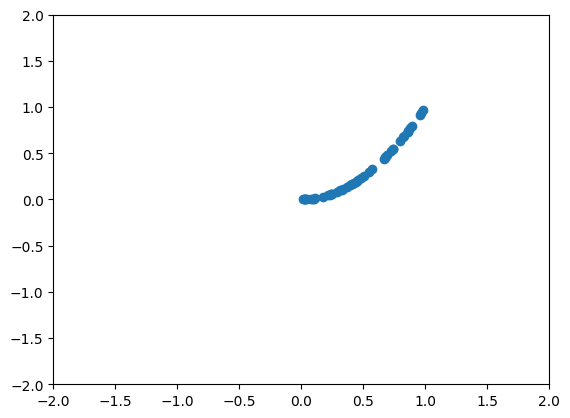

In [2]:
def manifold_func(x):
    return x**2

N_SAMPLES = 50000
x = torch.rand(size=(N_SAMPLES,))
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

fig, ax = plt.subplots()
ax.scatter(data[:50,0],data[:50,1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

In [3]:
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = data[idx]
        return data_item

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class ItoSDE(ABC):
    def __init__(self, T_max: float):
        self.T_max = T_max

    @abstractmethod
    def cond_exp(self, X_0: Tensor, t: Tensor):
        pass

    @abstractmethod
    def cond_var(self, X_0: Tensor, t: Tensor):
        pass

    @abstractmethod
    def f_drift(self, X_t: Tensor, t: Tensor):
        pass

    @abstractmethod
    def g_random(self, X_t: Tensor, t: Tensor):
        pass

    def cond_std(self, X_0: Tensor, t: Tensor):
        """Conditional standard deviation. Square root of self.cond_var."""
        return torch.sqrt(self.cond_var(X_0=X_0,t=t))

    def sample_random_times(self, length: int):
        """Sample 'length' time points uniformly in interval [0,T]"""
        return torch.rand(size=(length,))*self.T_max

    @staticmethod
    def _mult_first_dim(t,X):
        """
        Helper function to multiply one-dimensional time vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return t.view(-1,*[1]*(X.dim()-1))*X

    def run_forward(self, X_0: Tensor, t: Tensor, clip_factor: float = 0.01):
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = torch.randn(size=X_0.shape)
        cond_std = self.cond_std(X_0,t)
        cond_exp = self.cond_exp(X_0,t)
        X_t = self._mult_first_dim(cond_std,noise)+cond_exp
        if clip_factor is not None:
            cond_std = torch.clip(cond_std,min=clip_factor)
        score = -self._mult_first_dim(1/cond_std,noise)

        return X_t, noise, score

    def run_forward_random_times(self, X_0: Tensor):
        """Function to evolve SDE forward until random times."""
        t = self.sample_random_times(X_0.shape[0])
        X_t, noise, score = self.run_forward(X_0,t)
        return X_t, noise, score, t

In [5]:
class VPSDE(ItoSDE):
    def __init__(self,T_max: float, beta_min: float = 0.0, beta_max: float = 1.0):
       self.T_max = T_max
       self.beta_min = beta_min
       self.beta_max = beta_max

    def _beta_derivative(self, t: Tensor):
        return self.beta_min+(self.beta_max - self.beta_min)*t

    def _beta(self, t: Tensor):
        return (self.beta_min*t)+0.5*(self.beta_max - self.beta_min)*(t**2)

    def cond_exp(self, X_0: Tensor, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        assert t.shape[0] == X_0.shape[0]
        beta_t = self._beta(t)
        cond_exp_t = torch.exp(-0.5*beta_t)
        return self._mult_first_dim(cond_exp_t,X_0)

    def cond_var(self, X_0: Tensor, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        #assert t.shape[0] == X_0.shape[0]
        beta_t = self._beta(t)
        cond_var_t = 1-torch.exp(-beta_t)
        return cond_var_t


    def f_drift(self, X_t: Tensor, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        assert t.shape[0] == X_t.shape[0]
        deriv_beta_t = self._beta_derivative(t)
        return -0.5*self._mult_first_dim(deriv_beta_t,X_t)

    def g_random(self, t: Tensor):
        """
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:

        """
        assert len(t.shape) == 1, "Time must be 1-dimensional."
        deriv_beta_t = self._beta_derivative(t)
        return torch.sqrt(deriv_beta_t)

In [6]:
sde = VPSDE(T_max=1,beta_min=0.01, beta_max=2.0)

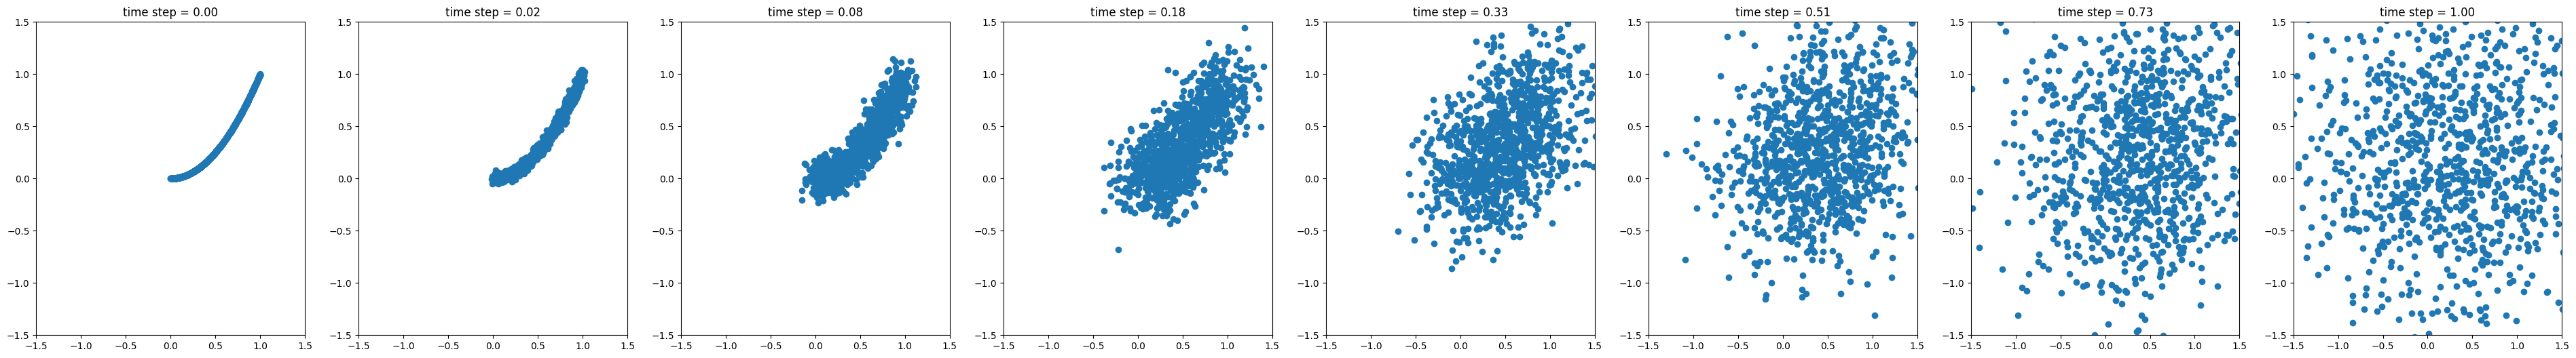

In [7]:
n_grid_points = 8
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0 = torch.stack([torch.stack([dataset.__getitem__(idx)]*n_grid_points) for idx in range(1000)]).transpose(1,0)
X_t, noise, score = sde.run_forward(X_0,time_vec)

fig, axs = plt.subplots(1,n_grid_points, figsize=(6*n_grid_points,6))
for idx in range(n_grid_points):
    axs[idx].scatter(X_t[idx,:,0],X_t[idx,:,1])
    axs[idx].set_xlim(-1.5,1.5)
    axs[idx].set_ylim(-1.5,1.5)
    axs[idx].set_title(f"time step = {time_vec[idx]:.2f}")

In [8]:
TRAIN_SCORE = False #whether to train score or denoiser network


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 2, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim+1, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x, t):
        x_conc_t = torch.concat([x,t.unsqueeze(1)],axis=1)
        x = F.relu(self.input_batch_norm(self.input_layer(x_conc_t)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)

In [10]:
model = FullConnectedScoreModel().cuda()

In [11]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
N_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
def train_diffusion_model(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, x_inp in enumerate(dataloader):

            #Zero gradients:
            optimizer.zero_grad()

            #Run forward samples:
            X_t,noise,score,time = sde.run_forward_random_times(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            score = score.to(device)
            time = time.to(device)

            #Predict score:
            model_pred = model(X_t,time)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.detach().item()

            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list

In [14]:
def plot_score_vector_field_modified(model=None, t=None, fpath=None, sde=None,
                                    min_x=-5.0, max_x=5.0, n_grid_points=100,
                                    ground_truth_score=True, train_score=False,
                                    arrow_scale=50, arrow_width=0.004,
                                    arrow_headwidth=1.5, arrow_headlength=2,
                                    arrow_color='blue', background_color='white',
                                    title=None, normalize_arrows=False):
    """
    Function to plot a score vector field with improved arrow visualization.

    Arguments:
        model: PyTorch model to evaluate
        t: Time parameter for the model
        fpath: Save image to this file path (if given)
        sde: SDE object
        min_x, max_x: Borders of grid (float)
        n_grid_points: Number of grid points (int)
        ground_truth_score: Whether to use ground truth score
        train_score: Whether to use training score
        arrow_scale: Scale factor for arrow size
        arrow_width: Width of arrow shaft
        arrow_headwidth: Width of arrow head
        arrow_headlength: Length of arrow head
        arrow_color: Color of arrows
        background_color: Background color of the plot
        title: Title for the plot
        normalize_arrows: Whether to normalize arrow lengths for better visualization

    Returns:
        Axis object with plot.
    """
    # Create grid
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x, y] for x, y in product(oned_grid, oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]

    # Evaluate model
    model.eval()
    time_vec = torch.tensor([t] * len(twod_grid)).float()
    model_estimate = model(torch.tensor(twod_grid).float(), time_vec).detach().cpu()

    # Calculate score
    if train_score:
        score = model_estimate
    else:
        denominator = torch.clip(sde.cond_std(None, time_vec), 0.01)
        if len(model_estimate.shape) == 4:
            score = -model_estimate / denominator[:, None, None, None]
        else:
            score = -model_estimate / denominator[:, None]

    # Setup plot
    fig, my_axis = plt.subplots(figsize=(1, 1), facecolor=background_color)
    my_axis.set_facecolor(background_color)

    # Optional: normalize arrow lengths for better visualization
    if normalize_arrows:
        # Calculate vector magnitudes
        magnitudes = np.sqrt(score[:, 0]**2 + score[:, 1]**2)

        # Avoid division by zero
        magnitudes = np.where(magnitudes > 0, magnitudes, 1)

        # Normalize vectors
        norm_score_x = score[:, 0] / magnitudes
        norm_score_y = score[:, 1] / magnitudes

        # Use normalized vectors for direction, but color by magnitude
        q = my_axis.quiver(
            twod_grid[:, 0], twod_grid[:, 1],
            norm_score_x, norm_score_y,
            magnitudes,  # Color by magnitude
            scale=arrow_scale,
            width=arrow_width,
            headwidth=arrow_headwidth,
            headlength=arrow_headlength,
            cmap='viridis',  # Use a colormap to represent magnitude
            pivot='mid'  # Center arrows on grid points
        )
        plt.colorbar(q, ax=my_axis, label='Vector magnitude')
    else:
        # Use original vectors
        q = my_axis.quiver(
            twod_grid[:, 0], twod_grid[:, 1],
            score[:, 0], score[:, 1],
            color=arrow_color,
            scale=arrow_scale,
            width=arrow_width,
            headwidth=arrow_headwidth,
            headlength=arrow_headlength,
            pivot='mid'  # Center arrows on grid points
        )

    # Add title if provided
    if title:
        my_axis.set_title(title, fontsize=14)

    # Add grid lines for better reference
    my_axis.grid(True, linestyle='--', alpha=0.6)

    # Set axis labels
    my_axis.set_xlabel('X', fontsize=12)
    my_axis.set_ylabel('Y', fontsize=12)

    # Save figure if path is provided
    if fpath is not None:
        plt.savefig(fpath, dpi=300, bbox_inches='tight')

    return my_axis

In [13]:
model,running_loss_list = train_diffusion_model(model, sde, trainloader, optimizer, device=device, n_epochs=N_EPOCHS, print_every=10)


Epoch: 0
1.1428515791893006
1.0484731793403625
0.9055803716182709
0.8373776197433471
0.7352996587753295
0.6519401013851166
0.6043067336082458
0.5756290137767792
0.5238650858402252
0.5184582769870758
0.4623507589101791
0.4370526194572449
0.4702490895986557
0.4003723233938217
0.3917829513549805
0.3909114122390747
0.3456863462924957
0.38541603088378906
0.37523655593395233
0.34816511869430544
0.35200963318347933
0.32219877541065217
0.33879410922527314
0.3278665363788605
0.33310507535934447
0.291772323846817
0.3005997747182846
0.27697878777980806
0.29664754271507265
0.3006920203566551
0.2971967697143555
0.30848299860954287
0.3125338852405548
0.3000633016228676
0.2913771033287048
0.3014596849679947
0.2861664012074471
0.30497237741947175
0.26984874457120894
Epoch: 1
0.3095938563346863
0.27485203742980957
0.2723493814468384
0.2809649437665939
0.3063789948821068
0.2790528923273087
0.26589730232954023
0.27755107581615446
0.2747278198599815
0.2622194990515709
0.2831303283572197
0.2507447689771652

In [42]:
def plot_score_vector_field_modified(model=None, t=None, fpath=None, sde=None,
                                   min_x=-2.0, max_x=2.0, n_grid_points=40,  # Reduced grid points for clearer arrows
                                   ground_truth_score=True, train_score=False):
    """
    Function to plot a score vector field with clear, uniform arrows.
    """
    # Create grid
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x, y] for x, y in product(oned_grid, oned_grid)])
    
    # Evaluate model
    model.to('cpu')
    model.eval()
    time_vec = torch.tensor([t] * len(twod_grid)).float()
    model_estimate = model(torch.tensor(twod_grid).float(), time_vec).detach().cpu()

    # Calculate score
    if train_score:
        score = model_estimate
    else:
        denominator = torch.clip(sde.cond_std(None, time_vec), 0.01)
        score = -model_estimate / denominator[:, None]

    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Normalize vectors for uniform arrow size
    score_magnitude = np.sqrt(score[:, 0]**2 + score[:, 1]**2)
    score_magnitude = np.where(score_magnitude > 0, score_magnitude, 1)
    normalized_score = score / score_magnitude[:, None]
    
    # Plot vector field with uniform arrows
    q = ax.quiver(twod_grid[:, 0], twod_grid[:, 1],
                 normalized_score[:, 0], normalized_score[:, 1],
                 color='black',
                 scale=30,  # Adjust this to change arrow density
                 width=0.004,  # Thinner arrows
                 headwidth=3,  # Wider arrow heads
                 headlength=5,  # Longer arrow heads
                 headaxislength=4.5,  # Adjust arrow head shape
                 pivot='middle')  # Center arrows on grid points

    # Customize plot appearance
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_x, max_x)
    ax.grid(True, linestyle='--', alpha=0.3)
    


    return ax

<Axes: xlabel='X', ylabel='Y'>

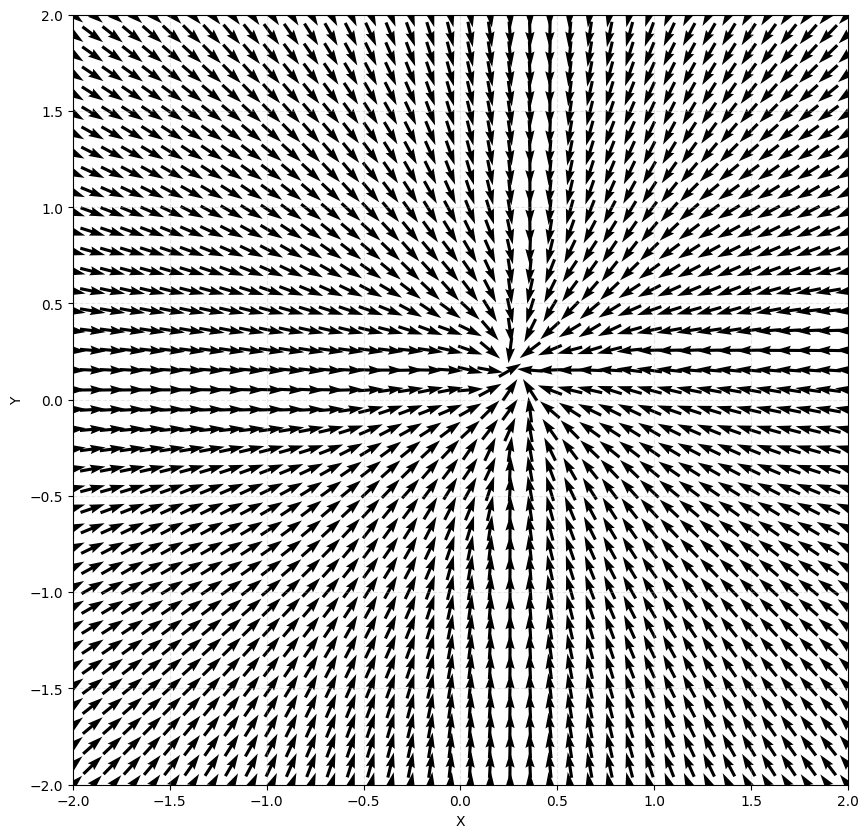

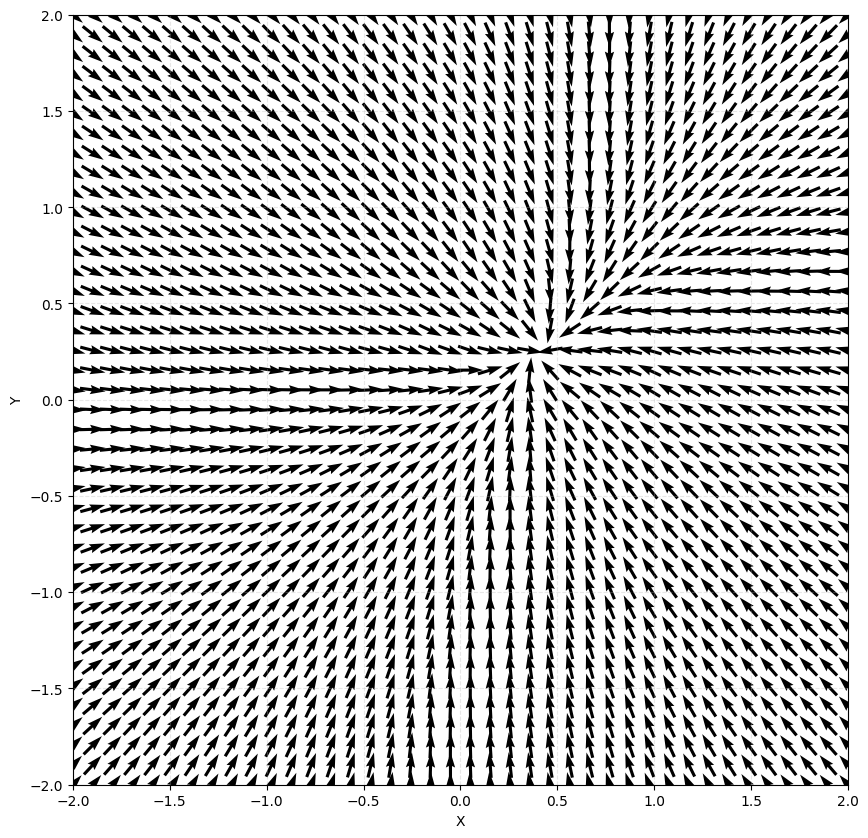

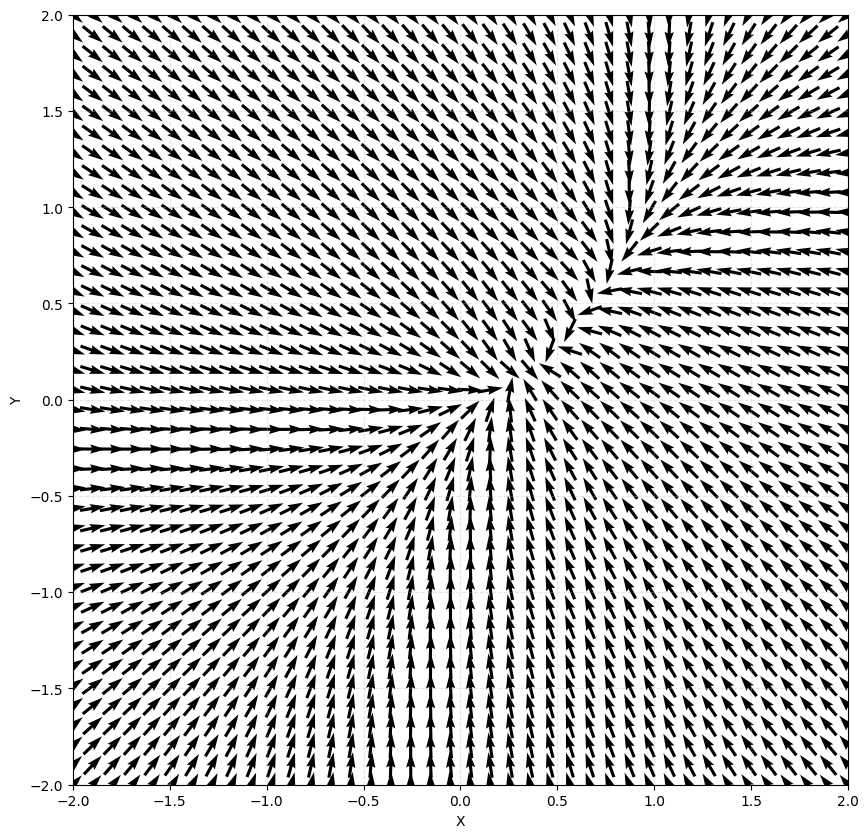

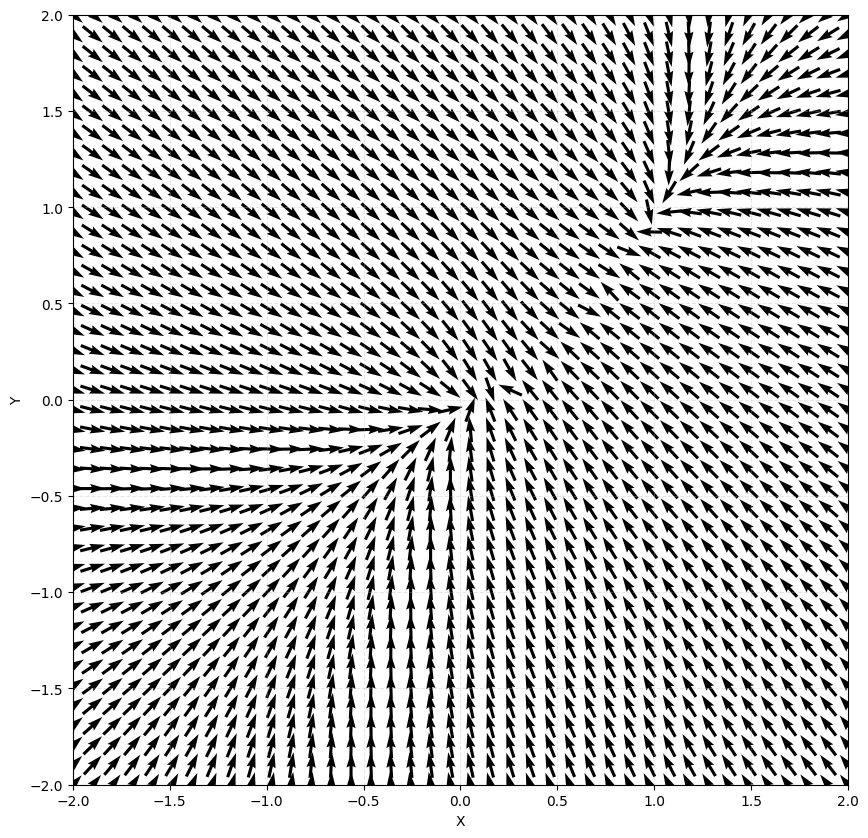

In [43]:
plot_score_vector_field_modified(model,t=1.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.5,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.25,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)
plot_score_vector_field_modified(model,t=0.0,min_x=-2.0,max_x=2.0, sde=sde, train_score=TRAIN_SCORE)

In [44]:
def run_backwards(model: torch.nn.Module, sde: ItoSDE, x_start: Tensor, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    model.eval()
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max,0,n_steps)
    step_size =torch.abs(time_grid[0]-time_grid[1])

    #Compute the random drift at every time point:
    random_drift_grid = sde.g_random(time_grid)

    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise * random_drift_grid.view(-1,*[1]*(ndim+1))

    #Initialize list of trajectory:
    x_traj = [x_start]

    if plot_evolution:
        fig, axs = plt.subplots(1,len(time_grid),figsize=(6*len(time_grid),6))


    for idx,time in tqdm(enumerate(time_grid)):

        #Get last location and time
        x = x_traj[idx]
        t = time_grid[idx]
        time_vec = t.repeat(n_traj)

        #Deterministic drift: f(X_,t)
        determ_drift = step_size*sde.f_drift(x,time_vec)

        #Get random drift:
        random_drift_sample = random_drift_grid_sample[idx]

        #Get noise estimates:
        model_estimate = model(x.to(device),time_vec.to(device)).detach().cpu()

        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, time_vec),0.01)
            if len(model_estimate.shape) == 4:
                score_estimates = -model_estimate/denominator[:,None,None,None]
            else:
                score_estimates = -model_estimate/denominator[:,None]

        #Correction term: g^2 * score estimate
        g_squared = (random_drift_grid[idx]**2).repeat(n_traj)
        correction_term = (step_size*ItoSDE._mult_first_dim(g_squared,score_estimates))

        #Compute next step:
        change = (correction_term - determ_drift) + random_drift_sample
        next_step = x + change

        #Save step:
        x_traj.append(next_step)

        if plot_evolution:
            axs[idx].scatter(next_step[:,0],next_step[:,1])
            axs[idx].quiver(next_step[:,0],next_step[:,1],change[:,0],change[:,1])
            axs[idx].set_xlim(-2.0,2.0)
            axs[idx].set_ylim(-2.0,2.0)
            axs[idx].set_title(f"Step={idx}")
    
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    return output,time_grid

0it [00:00, ?it/s]

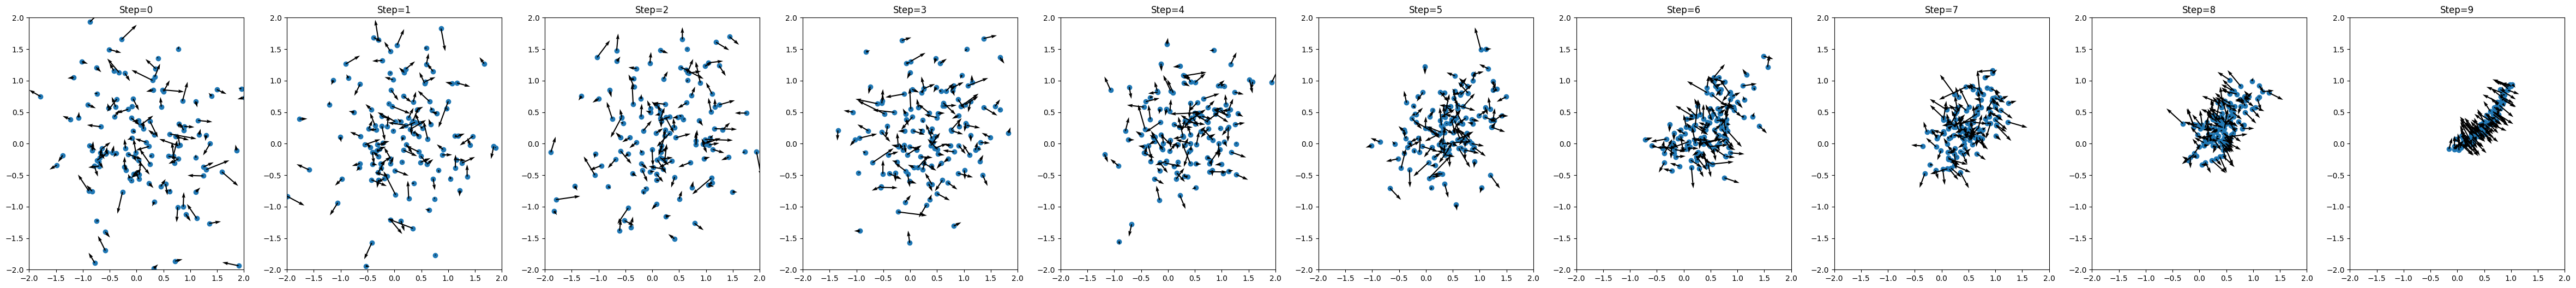

In [45]:
x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device, train_score=TRAIN_SCORE)

In [46]:
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML # to show the animation in Jupyter
# the camera gets the fig we'll plot

fig, axs = plt.subplots(figsize=(7,7))
camera = Camera(fig)
x_ref = np.linspace(0,1,100)
for idx in range(output.shape[0]):
    axs.plot(x_ref, manifold_func(x_ref),color='tab:red')
    axs.scatter(output[idx,:,0],output[idx,:,1],color='tab:blue')
    axs.set_xlim(-2.0,2.0)
    axs.set_ylim(-2.0,2.0)
    camera.snap()

animation = camera.animate() # animation ready
animation.save('diffusion_model_sampling.gif')
plt.close()

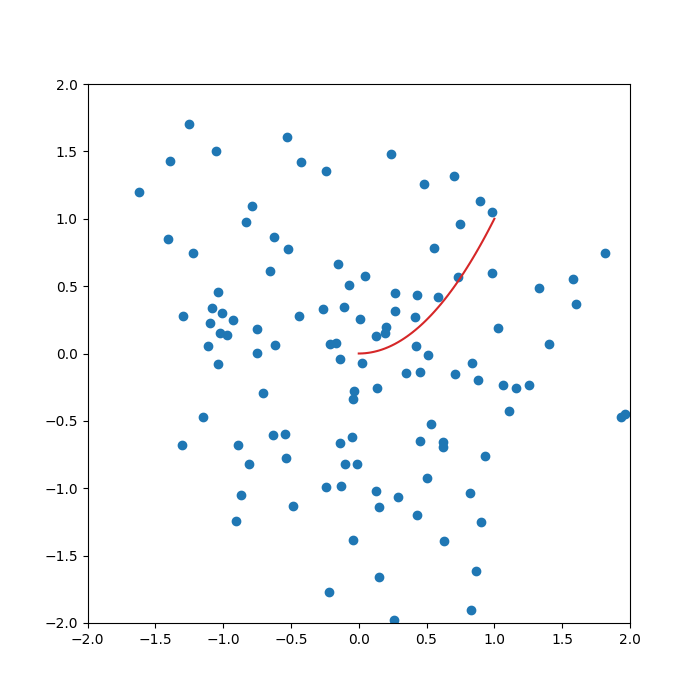

In [47]:
from IPython.display import Image
display(Image(filename='diffusion_model_sampling.gif'))